In [1]:
import csv
import datetime
import os
import numpy as np
import random
import math

from htm.bindings.sdr import SDR, Metrics
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.encoders.date import DateEncoder
from htm.bindings.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood 
#FIXME 代わりにTM.anomalyを使用しますが、 py.AnomalyLikelihoodよりも悪い結果になります
from htm.bindings.algorithms import Predictor

import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline

_INPUT_FILE_PATH ="gymdata.csv"

In [2]:
# 入力ファイルの読み込み.
records = []
with open(_INPUT_FILE_PATH, "r") as fin:
    reader = csv.reader(fin)
    headers = next(reader)
    next(reader)
    next(reader)
    for record in reader:
      records.append(record)

print(records)

[['7/2/10 0:00', '21.2'], ['7/2/10 1:00', '16.4'], ['7/2/10 2:00', '4.7'], ['7/2/10 3:00', '4.7'], ['7/2/10 4:00', '4.6'], ['7/2/10 5:00', '23.5'], ['7/2/10 6:00', '47.5'], ['7/2/10 7:00', '45.4'], ['7/2/10 8:00', '46.1'], ['7/2/10 9:00', '41.5'], ['7/2/10 10:00', '43.4'], ['7/2/10 11:00', '43.8'], ['7/2/10 12:00', '37.8'], ['7/2/10 13:00', '36.6'], ['7/2/10 14:00', '35.7'], ['7/2/10 15:00', '38.9'], ['7/2/10 16:00', '36.2'], ['7/2/10 17:00', '36.6'], ['7/2/10 18:00', '37.2'], ['7/2/10 19:00', '38.2'], ['7/2/10 20:00', '14.1'], ['7/2/10 21:00', '5.1'], ['7/2/10 22:00', '5'], ['7/2/10 23:00', '5.9'], ['7/3/10 0:00', '22.5'], ['7/3/10 1:00', '22.3'], ['7/3/10 2:00', '6'], ['7/3/10 3:00', '4.7'], ['7/3/10 4:00', '4.4'], ['7/3/10 5:00', '4.8'], ['7/3/10 6:00', '23.4'], ['7/3/10 7:00', '42.4'], ['7/3/10 8:00', '52'], ['7/3/10 9:00', '50.8'], ['7/3/10 10:00', '45.3'], ['7/3/10 11:00', '43.6'], ['7/3/10 12:00', '40.7'], ['7/3/10 13:00', '38.4'], ['7/3/10 14:00', '39.9'], ['7/3/10 15:00', '42.

In [3]:
 # エンコーダーを作成します。 これらは入力データをバイナリ表現に変換します.
dateEncoder = DateEncoder(timeOfDay= (30, 1), weekend  = 21) 

scalarEncoderParams            = RDSE_Parameters()
scalarEncoderParams.size       = 700
scalarEncoderParams.sparsity   = 0.02
scalarEncoderParams.resolution = 0.88
scalarEncoder = RDSE( scalarEncoderParams )
encodingWidth = (dateEncoder.size + scalarEncoder.size)
enc_info = Metrics( [encodingWidth], 999999999 )

print("-"*100)
print("Encoded Input", enc_info)
print("-"*100)

----------------------------------------------------------------------------------------------------
Encoded Input SDR( 1462 )
    Sparsity Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
    Activation Frequency Min/Mean/Std/Max 1234.57 / 1234.59 / 0.0222168 / 1234.57
    Entropy 0
    Overlap Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
----------------------------------------------------------------------------------------------------


In [4]:
# HTMを作る。 SpatialPoolerとTemporalMemoryと関連ツール.
sp = SpatialPooler(
    inputDimensions            = (encodingWidth,),
    columnDimensions           = (1638,),
    potentialPct               = 0.85,
    potentialRadius            = encodingWidth,
    globalInhibition           = True,
    localAreaDensity           = 0.04395604395604396,
    synPermInactiveDec         = 0.006,
    synPermActiveInc           = 0.04,
    synPermConnected           = 0.13999999999999999,
    boostStrength              = 3.0,
    wrapAround                 = True
)
sp_info = Metrics( sp.getColumnDimensions(), 999999999 )

print("-"*100)
print("Spatial Pooler Mini-Columns", sp_info)
print("-"*100)
print(sp)
print("-"*100)

----------------------------------------------------------------------------------------------------
Spatial Pooler Mini-Columns SDR( 1638 )
    Sparsity Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
    Activation Frequency Min/Mean/Std/Max 1234.57 / 1234.59 / 0.0260008 / 1234.57
    Entropy 0
    Overlap Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
----------------------------------------------------------------------------------------------------
Spatial Pooler Connections:
    Inputs (1462) ~> Outputs (1638) via Segments (1638)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 1243 / 1243 / 1243
    Connected Synapses on Segment Min/Mean/Max 566 / 621.681 / 676
    Synapses Dead (1.47345e-06%) Saturated (4.91151e-07%)
    Synapses pruned (0%) Segments pruned (0%)

----------------------------------------------------------------------------------------------------


In [5]:
tm = TemporalMemory(
    columnDimensions          = (1638,), #sp.columnDimensions
    cellsPerColumn            = 13,
    activationThreshold       = 17,
    initialPermanence         = 0.21,
    connectedPermanence       = 0.13999999999999999, #sp.synPermConnected
    minThreshold              = 10,
    maxNewSynapseCount        = 32,
    permanenceIncrement       = 0.1,
    permanenceDecrement       = 0.1,
    predictedSegmentDecrement = 0.0,
    maxSegmentsPerCell        = 128,
    maxSynapsesPerSegment     = 64
)
tm_info = Metrics( [tm.numberOfCells()], 999999999 )

print("-"*100)
print("Temporal Memory Cells", tm_info)
print("-"*100)
print(tm)
print("-"*100)

----------------------------------------------------------------------------------------------------
Temporal Memory Cells SDR( 21294 )
    Sparsity Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
    Activation Frequency Min/Mean/Std/Max 1234.57 / 1234.49 / 0.08094 / 1234.57
    Entropy 0
    Overlap Min/Mean/Std/Max inf / 1234.57 / 35.1364 / -inf
----------------------------------------------------------------------------------------------------
Temporal Memory Connections:
    Inputs (0) ~> Outputs (21294) via Segments (0)
    Segments on Cell Min/Mean/Max 0 / 0 / 0
    Potential Synapses on Segment Min/Mean/Max 4294967295 / nan / 0
    Connected Synapses on Segment Min/Mean/Max 65535 / nan / 0
    Synapses Dead (nan%) Saturated (nan%)
    Synapses pruned (nan%) Segments pruned (nan%)

----------------------------------------------------------------------------------------------------


In [6]:
tm.activateDendrites(True)
print(tm.getPredictiveCells())

SDR( 1638, 13 )


In [7]:
# セットアップ尤度（ゆうど）は、これらの設定が NAB
# これらの設定は、NABからコピーされます
probationaryPeriod = int(math.floor(float(0.1)*len(records)))
learningPeriod     = int(math.floor(probationaryPeriod / 2.0))
anomaly_history = AnomalyLikelihood(learningPeriod= learningPeriod,
                                  estimationSamples= probationaryPeriod - learningPeriod,
                                  reestimationPeriod= 100)

predictor = Predictor( steps=[1, 5], alpha=0.1)
predictor_resolution = 1

In [8]:
# データセット内のすべてのデータを反復処理し、入力と出力を記録します.
inputs      = []
anomaly     = []
anomalyProb = []
predictions = {1: [], 5: []}

In [12]:
for count, record in enumerate(records):

    # 日付文字列をPythonの日付オブジェクトに変換する.
    dateString = datetime.datetime.strptime(record[0], "%m/%d/%y %H:%M")
    # データ値の文字列をfloatに変換.
    consumption = float(record[1])
    inputs.append( consumption )

    # エンコーダを呼び出して、各値のビット表現を作成します。 これらは SDR オブジェクトです.
    dateBits        = dateEncoder.encode(dateString)
    consumptionBits = scalarEncoder.encode(consumption)

    # これらのすべてのエンコーディングを 1 つの大きなエンコーディングに連結して、
    # 空間プーリング用に使用します.
    encoding = SDR( encodingWidth ).concatenate([consumptionBits, dateBits])
    enc_info.addData( encoding )

    # これは、以下の計算方法で作成されます
    # Spatial Poolerと同じ寸法でなければなりません
    activeColumns = SDR( sp.getColumnDimensions() )

    # 入力空間に対する空間プーリングアルゴリズムの実行.
    sp.compute(encoding, True, activeColumns)
    sp_info.addData( activeColumns )

    # アクティブなミニカラムに対してTemporal Memoryアルゴリズムを実行する.
    tm.compute(activeColumns, learn=True)
    tm_info.addData( tm.getActiveCells().flatten() )
    
    #clear_output(wait = True)
    #print("SPactiveColumns",activeColumns)
    #print("ActiveCells",tm.getActiveCells())
    #print("WinnerCells",tm.getWinnerCells())
    #tm.activateDendrites(True)
    #print("PredictiveCells",tm.getPredictiveCells())
    #print("Anomaly", tm.anomaly * 100, "%")

    # 何が起こるかを予測し、今起こったことに基づいて予測器を訓練する.
    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1,5):
        if pdf[n]:
            predictions[n].append( np.argmax( pdf[n] ) * predictor_resolution )
        else:
            predictions[n].append(float('nan'))
        
    anomalyLikelihood = anomaly_history.anomalyProbability( consumption, tm.anomaly )
    
    anomaly.append( tm.anomaly )
    anomalyProb.append( anomalyLikelihood )

    predictor.learn(count, tm.getActiveCells(), int(consumption / predictor_resolution))

In [13]:
    # 予測器に部分的な情報を与え、
    # 将来の予測をする。
    predictor.reset()
    A = predictor.infer( tm.getActiveCells())

    print(A)
    print(np.argmax( A[1] ) )
    print(np.argmax( A[5] ) )

{5: [5.181961875712095e-05, 5.181961875712095e-05, 5.181961875712095e-05, 5.181961875712095e-05, 0.0005743403936019415, 0.9936537748999548, 3.4016610845630874e-07, 8.855824806303999e-05, 0.0003347034192004841, 5.180942235738447e-05, 5.6701085825240704e-05, 5.507873441122346e-05, 4.8248923808182664e-05, 0.00028437051671629686, 6.229821818665234e-05, 5.627383625624605e-05, 9.828025918419784e-05, 0.00010021917238825025, 9.891767763637633e-05, 5.004173173125372e-05, 8.364319927623051e-05, 0.0001186337258459478, 9.636339653029056e-05, 5.442284076023705e-05, 5.117533953885309e-05, 6.057547863123602e-05, 5.643227541120802e-05, 5.198786163441073e-05, 4.9246894847129754e-05, 5.197392703815775e-05, 5.1980420499873474e-05, 5.377475518198862e-05, 5.729197779280024e-05, 5.191663952148137e-05, 5.215860885553804e-05, 4.8981241144004014e-05, 3.88314878214375e-05, 6.321052749787628e-05, 0.00011535290403432757, 7.143376388494059e-05, 2.0592139235574366e-05, 3.305153655641732e-05, 2.3402425910151233e-05,

In [13]:
# HTMの状態に関する情報と統計を印刷する.
print("-"*100)
print(sp)
print("-"*100)
print(tm)
print("-"*100)

----------------------------------------------------------------------------------------------------
Spatial Pooler Connections:
    Inputs (1462) ~> Outputs (1638) via Segments (1638)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 1243 / 1243 / 1243
    Connected Synapses on Segment Min/Mean/Max 73 / 208.339 / 656
    Synapses Dead (0.734759%) Saturated (0.0347533%)
    Synapses pruned (0%) Segments pruned (0%)

----------------------------------------------------------------------------------------------------
Temporal Memory Connections:
    Inputs (7682) ~> Outputs (21294) via Segments (10186)
    Segments on Cell Min/Mean/Max 0 / 0.478351 / 2
    Potential Synapses on Segment Min/Mean/Max 32 / 37.1029 / 64
    Connected Synapses on Segment Min/Mean/Max 28 / 36.2333 / 64
    Synapses Dead (0%) Saturated (0.599042%)
    Synapses pruned (0.412346%) Segments pruned (0%)

-----------------------------------------------------------------------

In [14]:
# 予測した入力と一致するように予測値をシフトする.
for n_steps, pred_list in predictions.items():
    for x in range(n_steps):
        pred_list.insert(0, float('nan'))
        pred_list.pop()

# 予測精度、Root-Mean-Squaredを計算します
accuracy         = {1: 0, 5: 0}
accuracy_samples = {1: 0, 5: 0}

for idx, inp in enumerate(inputs):
    for n in predictions: # 予測された各[N]ステップ先の時間ステップ数について.
        val = predictions[n][ idx ]
        if not math.isnan(val):
            accuracy[n] += (inp - val) ** 2
            accuracy_samples[n] += 1

for n in sorted(predictions):
    accuracy[n] = (accuracy[n] / accuracy_samples[n]) ** .5
    print("Predictive Error (RMS)", n, "steps ahead:", accuracy[n])

Predictive Error (RMS) 1 steps ahead: 7.8545900741192245
Predictive Error (RMS) 5 steps ahead: 9.008883363217393


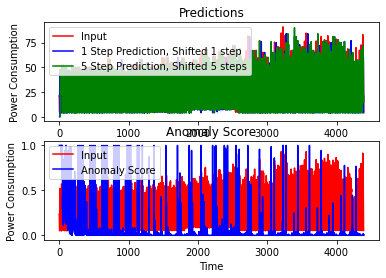

In [15]:
plt.subplot(2,1,1)
plt.title("Predictions")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
plt.plot(np.arange(len(inputs)), inputs, 'red',
         np.arange(len(inputs)), predictions[1], 'blue',
         np.arange(len(inputs)), predictions[5], 'green',)
plt.legend(labels=('Input', '1 Step Prediction, Shifted 1 step', '5 Step Prediction, Shifted 5 steps'))

plt.subplot(2,1,2)
plt.title("Anomaly Score")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
inputs = np.array(inputs) / max(inputs)
plt.plot(np.arange(len(inputs)), inputs, 'red',
         np.arange(len(inputs)), anomaly, 'blue',)
plt.legend(labels=('Input', 'Anomaly Score'))
plt.show()